## Final Project Submission

Please fill out:
* Student name: Joshua Ko
* Student pace: part time
* Scheduled project review date/time: 1/20/2023 1:00 PM
* Instructor name: Mark Barbour
* Blog post URL:


# Movie ROI Project

## Goal: What drives the ROI of movies?

>In order to answer this question my first step is to gather data. For this particular project, I used the data supplied by '_The Numbers_', '_The Movies Database_', and '_IMDB_'. Once the data is cleaned and successfully merged, I will be able to see if there are relationships between the ROI and some independent variable (genre, directors, or actors/actresses).

Importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, StrMethodFormatter

import seaborn as sns

Then move into the folder containing the data.

In [2]:
cd Data/

C:\Users\joshu\Documents\Flatiron\phase1_project\phase1_project\Data


Using pandas, the two csv files can be converted into a dataframe.

In [3]:
movie_ratings = pd.read_csv('tmdb.movies.csv.gz')
budget = pd.read_csv('tn.movie_budgets.csv.gz')

## Data Cleaning
>The dataframe will now have to be inspected to determine what values need alteration, where the _NaN_ values are, and what columns can be dropped. To inspect the dataframes `.head()` and `.info()` was used.

In [4]:
#Drop the 'Unnamed: 0' column as it provides no useful values
movie_ratings = movie_ratings.drop('Unnamed: 0', axis=1)

#Changing the movie title so that we can merge with the databases along 'movie'
movie_ratings = movie_ratings.replace('Star Wars: The Last Jedi', 'Star Wars Ep. VIII: The Last Jedi')
movie_ratings = movie_ratings.replace('Star Wars: The Force Awakens', 'Star Wars Ep. VII: The Force Awakens')

#Thinning out the data so it only includes data with a significant amount of votes
movie_ratings = movie_ratings[movie_ratings.vote_count >= 50]

#The date has to be changed from 'object' to 'datatime' so that the values of the 'release date' can be changed
#so that it matches the date format of the other database.
movie_ratings['release_date'] = pd.to_datetime(movie_ratings['release_date'])
movie_ratings['release_date'] = movie_ratings['release_date'].dt.strftime('%b %d, %Y')

#Renaming the column so the databases can be merged along the column 'movie'
movie_ratings = movie_ratings.rename(columns={'original_title': 'movie'})
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5108 entries, 0 to 25148
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          5108 non-null   object 
 1   id                 5108 non-null   int64  
 2   original_language  5108 non-null   object 
 3   movie              5108 non-null   object 
 4   popularity         5108 non-null   float64
 5   release_date       5108 non-null   object 
 6   title              5108 non-null   object 
 7   vote_average       5108 non-null   float64
 8   vote_count         5108 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 399.1+ KB


Drop useless columns.

In [5]:
movie_ratings = movie_ratings.drop(['genre_ids', 'id', 'original_language', 'title'], axis=1)

Next, we clean the `budget` database.
>Since the values in these columns (`production_budget`, `domestic_gross`, `worldwide_gross`) are not integers, they have to be converted into `int64` or `float64`. We will use `float64` just in case there are values in the decimal places. In order to do this, any symbols and commas must be removed from the values.

In [6]:
budget['production_budget'] = budget['production_budget'].map(lambda x: x.lstrip('$'))
budget['domestic_gross'] = budget['domestic_gross'].map(lambda x: x.lstrip('$'))
budget['worldwide_gross'] = budget['worldwide_gross'].map(lambda x: x.lstrip('$'))

budget['production_budget'] = budget['production_budget'].replace(',', '', regex=True)
budget['domestic_gross'] = budget['domestic_gross'].replace(',', '', regex=True)
budget['worldwide_gross'] = budget['worldwide_gross'].replace(',', '', regex=True)
budget['domestic_gross'] = budget['domestic_gross'].astype('float64')
budget['worldwide_gross'] = budget['worldwide_gross'].astype('float64')
budget['production_budget'] = budget['production_budget'].astype('float64')

#Create a new column of values that shows us the profits made for each movie
budget['ROI'] = budget['domestic_gross'] + budget['worldwide_gross'] - budget['production_budget']
budget['Percent_change'] = (budget['ROI'] / budget['production_budget'] *100)

#Check columns and rows
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
 6   ROI                5782 non-null   float64
 7   Percent_change     5782 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 361.5+ KB


After further inspection of the dataframe, it was discovered that there are rows were both `domestic_gross` and `worldwide_gross` was zero. The rows containing these errors should be removed.

In [7]:
budget = budget[(budget['domestic_gross'] > 0) & (budget['worldwide_gross'] > 0)]

#We can check how many rows were removed as a result of this line of code.
budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5234 non-null   int64  
 1   release_date       5234 non-null   object 
 2   movie              5234 non-null   object 
 3   production_budget  5234 non-null   float64
 4   domestic_gross     5234 non-null   float64
 5   worldwide_gross    5234 non-null   float64
 6   ROI                5234 non-null   float64
 7   Percent_change     5234 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 368.0+ KB


Now that the dataframes have been cleaned, we can merge the two using `outer` so that we can preserve as many rows as we can.
Just in case there are different movies with the same title, we can merge both dataframes on `release_date` and `movies`, as the likelihood of a movie having the same title and release date is very unlikely.

In [8]:
merged = pd.merge(budget, movie_ratings, how='outer', left_on=['movie','release_date'], right_on=['movie','release_date'])

#The popularity column is dropped as it creates many NaN values.
merged = merged.drop('popularity', axis=1)

#Another method of checking
merged.sample(5, random_state=42)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,Percent_change,vote_average,vote_count
2210,3.0,"Dec 9, 1983",Scarface,25000000.0,44942821.0,44942821.0,64885642.0,259.542568,NaN,NaN
2907,27.0,"Jun 2, 1989",Dead Poets Society,16400000.0,95860116.0,239500000.0,318960116.0,1944.878756,NaN,NaN
1530,9.0,"Oct 23, 2009",Cirque du Freak: The Vampire's Assistant,40000000.0,14046595.0,39753957.0,13800552.0,34.501380,NaN,NaN
5853,NaN,"Oct 14, 2011",Chillerama,NaN,NaN,NaN,NaN,NaN,5.7,50.0
4074,63.0,"Mar 14, 2014",Veronica Mars,6000000.0,3322127.0,3485383.0,807510.0,13.458500,6.7,699.0


## Working with the SQL Tables
>First a connection must be made to the database. We can see that the connection is made if the names of the tables are returned.

Before making the connection, move into the folder containing the imdb data.

In [13]:
cd im.db

C:\Users\joshu\Documents\Flatiron\phase1_project\im.db


In [14]:
conn = sqlite3.connect('im.db')

cur = conn.cursor()
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")

table_names = cur.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

We are only using `directors`, `writers`, `persons`, and `movie_ratings`. These tables are joined through `person_id` or `movie_id`. The only columns we need to `SELECT` from each tables are `primary_name`, `primary_title`, `genres`, `averagerating`, and `numvotes`.

In [15]:
directors = pd.read_sql("""
SELECT primary_name, primary_title, genres, averagerating, numvotes
  FROM directors
JOIN persons
    ON persons.person_id = directors.person_id
JOIN movie_basics
    ON movie_basics.movie_id = directors.movie_id
JOIN movie_ratings
    ON movie_ratings.movie_id = directors.movie_id
ORDER BY averagerating DESC
;
""", conn)

In [16]:
writers = pd.read_sql("""
SELECT primary_name, primary_title, genres, averagerating, numvotes
  FROM writers
JOIN persons
    ON persons.person_id = writers.person_id
JOIN movie_basics
    ON movie_basics.movie_id = writers.movie_id
JOIN movie_ratings
    ON movie_ratings.movie_id = writers.movie_id
ORDER BY averagerating DESC
;
""", conn)

In [17]:
famousppl = pd.read_sql("""
SELECT primary_name, primary_profession, primary_title, genres, averagerating, numvotes
  FROM known_for
JOIN persons
    ON persons.person_id = known_for.person_id
JOIN movie_basics
    ON movie_basics.movie_id = known_for.movie_id
JOIN movie_ratings
    ON movie_ratings.movie_id = known_for.movie_id
ORDER BY averagerating DESC
;
""", conn)

Since we are planning to merge the previously merged dataframe to these new dataframes, the columns are renamed. To prevent duplication we can `.drop_duplicates()` or change the title of the movie so that the values merge accordingly.

In [18]:
directors = directors.rename(columns={'primary_title': 'movie',
                                      'averagerating':'vote_average',
                                      'primary_name': 'director'})

directors = directors.replace('Star Wars: The Last Jedi',
                              'Star Wars Ep. VIII: The Last Jedi')
directors = directors.replace('Star Wars: Episode VII - The Force Awakens',
                              'Star Wars Ep. VII: The Force Awakens')
directors = directors.replace('Harry Potter and the Deathly Hallows: Part 2',
                              'Harry Potter and the Deathly Hallows: Part II')
directors = directors.replace('Harry Potter and the Deathly Hallows: Part 1',
                              'Harry Potter and the Deathly Hallows: Part I')

#We can also clean up the data for genre that will be used to relate genre with ROI.
directors['genres'] = directors['genres'].replace(',', ', ', regex=True)

directors = directors[directors['numvotes'] >= 50]
directors = directors.drop_duplicates(subset=['movie', 'director'])
directors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42316 entries, 21 to 181361
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   director      42316 non-null  object 
 1   movie         42316 non-null  object 
 2   genres        42219 non-null  object 
 3   vote_average  42316 non-null  float64
 4   numvotes      42316 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


In [19]:
writers = writers.rename(columns={'primary_title': 'movie',
                                  'averagerating':'vote_average',
                                  'primary_name': 'writer'})
writers = writers.replace('Star Wars: The Last Jedi',
                              'Star Wars Ep. VIII: The Last Jedi')
writers = writers.replace('Star Wars: Episode VII - The Force Awakens',
                              'Star Wars Ep. VII: The Force Awakens')
writers = writers.replace('Harry Potter and the Deathly Hallows: Part 2',
                              'Harry Potter and the Deathly Hallows: Part II')
writers = writers.replace('Harry Potter and the Deathly Hallows: Part 1',
                              'Harry Potter and the Deathly Hallows: Part I')

writers = writers[writers['numvotes'] >= 50]
writers = writers.drop_duplicates(subset=['movie', 'writer'])
writers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64807 entries, 20 to 169294
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   writer        64807 non-null  object 
 1   movie         64807 non-null  object 
 2   genres        64727 non-null  object 
 3   vote_average  64807 non-null  float64
 4   numvotes      64807 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 3.0+ MB


In [20]:
famousppl = famousppl.rename(columns={'primary_title': 'movie',
                                      'averagerating':'vote_average',
                                      'primary_name': 'renown'})

famousppl = famousppl.replace('Star Wars: The Last Jedi',
                              'Star Wars Ep. VIII: The Last Jedi')
famousppl = famousppl.replace('Star Wars: Episode VII - The Force Awakens',
                              'Star Wars Ep. VII: The Force Awakens')
famousppl = famousppl.replace('Harry Potter and the Deathly Hallows: Part 2',
                              'Harry Potter and the Deathly Hallows: Part II')
famousppl = famousppl.replace('Harry Potter and the Deathly Hallows: Part 1',
                              'Harry Potter and the Deathly Hallows: Part I')


famousppl = famousppl[famousppl['numvotes'] >= 50]
famousppl = famousppl.drop_duplicates(subset=['movie', 'renown'])
famousppl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318243 entries, 68 to 526727
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   renown              318243 non-null  object 
 1   primary_profession  310778 non-null  object 
 2   movie               318243 non-null  object 
 3   genres              317656 non-null  object 
 4   vote_average        318243 non-null  float64
 5   numvotes            318243 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 17.0+ MB


## Even More Data Cleaning
>Now that the data from the SQL is cleaned, we can merge the two dataframes (i.e. `directors` and `merged`). However, we must merge the two in order to replace some `NaN` values. This causes even more data cleaning.

In [21]:
directors_ROI = pd.merge(directors, merged, how='left', left_on='movie', right_on='movie')
writers_ROI = pd.merge(writers, merged, how='left', left_on='movie', right_on='movie')
famousppl_ROI = pd.merge(famousppl, merged, how='left', left_on='movie', right_on='movie')

After merging, we can fill in any `NaN` values that exists in the `vote_average_x` and `vote_count` columns.

In [22]:
directors_ROI['rating_average'] = directors_ROI['vote_average_x'].fillna(directors_ROI['vote_average_y'])
directors_ROI['vote_count'] = directors_ROI['vote_count'].fillna(directors_ROI['numvotes'])
writers_ROI['rating_average'] = writers_ROI['vote_average_x'].fillna(writers_ROI['vote_average_y'])
writers_ROI['vote_count'] = writers_ROI['vote_count'].fillna(writers_ROI['numvotes'])
famousppl_ROI['rating_average'] = famousppl_ROI['vote_average_x'].fillna(famousppl_ROI['vote_average_y'])
famousppl_ROI['vote_count'] = famousppl_ROI['vote_count'].fillna(famousppl_ROI['numvotes'])

We can clean the data further by dropping the columns that will not be used.

In [23]:
directors_ROI = directors_ROI.drop(['id', 'numvotes', 'vote_average_x', 'vote_average_y'], axis=1)
writers_ROI = writers_ROI.drop(['id', 'numvotes', 'vote_average_x', 'vote_average_y'], axis=1)
famousppl_ROI = famousppl_ROI.drop(['id', 'numvotes', 'vote_average_x', 'vote_average_y'], axis=1)

Now the duplicates and `NaN` values can be dropped without losing too much data.

In [24]:
directors_ROI = directors_ROI.drop_duplicates(subset=['movie', 'director'])
directors_ROI = directors_ROI.dropna()

writers_ROI = writers_ROI.drop_duplicates(subset=['movie', 'writer'])
writers_ROI = writers_ROI.dropna()

famousppl_ROI = famousppl_ROI.drop_duplicates(subset=['movie', 'renown'])
famousppl_ROI = famousppl_ROI.dropna()

Inspection using `.info()`

In [25]:
directors_ROI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2195 entries, 144 to 43403
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   director           2195 non-null   object 
 1   movie              2195 non-null   object 
 2   genres             2195 non-null   object 
 3   release_date       2195 non-null   object 
 4   production_budget  2195 non-null   float64
 5   domestic_gross     2195 non-null   float64
 6   worldwide_gross    2195 non-null   float64
 7   ROI                2195 non-null   float64
 8   Percent_change     2195 non-null   float64
 9   vote_count         2195 non-null   float64
 10  rating_average     2195 non-null   float64
dtypes: float64(7), object(4)
memory usage: 205.8+ KB


In [26]:
writers_ROI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4677 entries, 135 to 67205
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   writer             4677 non-null   object 
 1   movie              4677 non-null   object 
 2   genres             4677 non-null   object 
 3   release_date       4677 non-null   object 
 4   production_budget  4677 non-null   float64
 5   domestic_gross     4677 non-null   float64
 6   worldwide_gross    4677 non-null   float64
 7   ROI                4677 non-null   float64
 8   Percent_change     4677 non-null   float64
 9   vote_count         4677 non-null   float64
 10  rating_average     4677 non-null   float64
dtypes: float64(7), object(4)
memory usage: 438.5+ KB


In [27]:
famousppl_ROI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47557 entries, 614 to 345555
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   renown              47557 non-null  object 
 1   primary_profession  47557 non-null  object 
 2   movie               47557 non-null  object 
 3   genres              47557 non-null  object 
 4   release_date        47557 non-null  object 
 5   production_budget   47557 non-null  float64
 6   domestic_gross      47557 non-null  float64
 7   worldwide_gross     47557 non-null  float64
 8   ROI                 47557 non-null  float64
 9   Percent_change      47557 non-null  float64
 10  vote_count          47557 non-null  float64
 11  rating_average      47557 non-null  float64
dtypes: float64(7), object(5)
memory usage: 4.7+ MB


## Preparing Plots using Seaborn and Matplotlib
>After further data manipulation, the data can be plotted to determine relationships between the ROI and whatever variable we choose. In this project we are focusing on `directors`, `writers`, `actors/actresses` and `genre`.

Divide up `directors_ROI` to create three tiers:
* `Highest ROI`
* `Mid ROI`
* `Lowest ROI`

This was done by creating a new column `.assign(Rank= '')` and categorizing the rows according to their ROI. 
<br>We can then concatenate the three databases together by `pd.concat([databases here])`.

In [28]:
top_directors = directors_ROI.sort_values(by='ROI', ascending=False)
top_directors = top_directors.iloc[:220]

bot_directors = directors_ROI.sort_values(by='ROI', ascending=True)
bot_directors = bot_directors.iloc[:220]

mid_directors = directors_ROI.sort_values(by='ROI', ascending=True)
mid_directors = mid_directors.iloc[730:1430]

dir_1 = top_directors.assign(Rank='Highest ROI')
dir_2 = mid_directors.assign(Rank='Mid ROI')
dir_3 = bot_directors.assign(Rank='Lowest ROI')

concat_directors = pd.concat([dir_1, dir_2, dir_3])
concat_directors.head()

,director,movie,genres,release_date,production_budget,domestic_gross,worldwide_gross,ROI,Percent_change,vote_count,rating_average,Rank
2006,J.J. Abrams,Star Wars Ep. VII: The Force Awakens,"Action, Adventure, Fantasy","Dec 18, 2015",306000000.0,936662225.0,2.053311e+09,2.683973e+09,877.115505,12641.0,8.0,Highest ROI
719,Anthony Russo,Avengers: Infinity War,"Action, Adventure, Sci-Fi","Apr 27, 2018",300000000.0,678815482.0,2.048134e+09,2.426950e+09,808.983227,13948.0,8.5,Highest ROI
720,Joe Russo,Avengers: Infinity War,"Action, Adventure, Sci-Fi","Apr 27, 2018",300000000.0,678815482.0,2.048134e+09,2.426950e+09,808.983227,13948.0,8.5,Highest ROI
10741,Colin Trevorrow,Jurassic World,"Action, Adventure, Sci-Fi","Jun 12, 2015",215000000.0,652270625.0,1.648855e+09,2.086125e+09,970.290925,14056.0,7.0,Highest ROI
1827,Joss Whedon,The Avengers,"Action, Adventure, Sci-Fi","May 4, 2012",225000000.0,623279547.0,1.517936e+09,1.916215e+09,851.651308,1183655.0,8.1,Highest ROI


__Creating a box-and-whisker graph to compare the ratings of the different levels of ROI.__

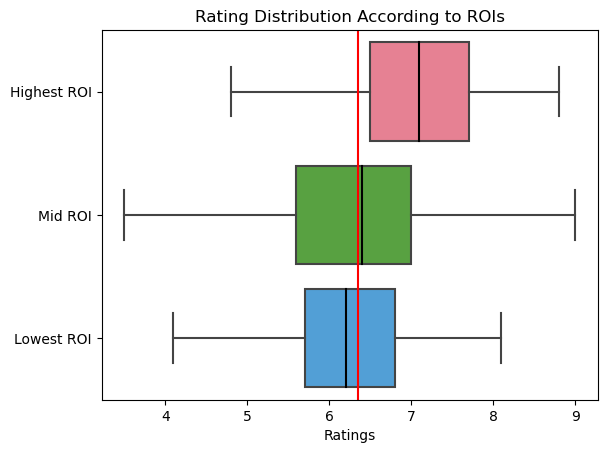

In [29]:
fig = sns.boxplot(
    data=concat_directors,
    x='rating_average',
    y='Rank',
    medianprops={'color': 'black'},
    orient='h',
    showfliers=False,
    palette='husl'
).set(title='Rating Distribution According to ROIs')
plt.xlabel('Ratings')
plt.ylabel('')

# This vertical line represents the mean. It is calculated below.
plt.axvline(6.35, color='red')

Here, we can conclude that ratings generally do play a role in ROI. More than 75% of the high ROI films had ratings that were higher than the average rating.

__Creating a scatterplot graph that shows which directors had the highest ROI__

Obtaining some values for specific directors.
* To find if a particular director is in the data we used `.str.contains(**director name**)`

In [30]:
russo = directors_ROI.loc[directors_ROI['director'].str.contains('Joe Russo')]
whedon = directors_ROI.loc[directors_ROI['director'].str.contains('Whedon')]
abrams = directors_ROI.loc[directors_ROI['director'].str.contains('J.J. Abrams')]
spielberg = directors_ROI.loc[directors_ROI['director'].str.contains('Steven Spielberg')]
wan = directors_ROI.loc[directors_ROI['director'].str.contains('James Wan')]
bay = directors_ROI.loc[directors_ROI['director'].str.contains('Michael Bay')]

some_directors = pd.concat([russo, whedon, abrams, spielberg, wan, bay])

Create the scatterplot graph that plots the ROIs of these directors relative to the `top_director`.

<Figure size 2000x1200 with 0 Axes>

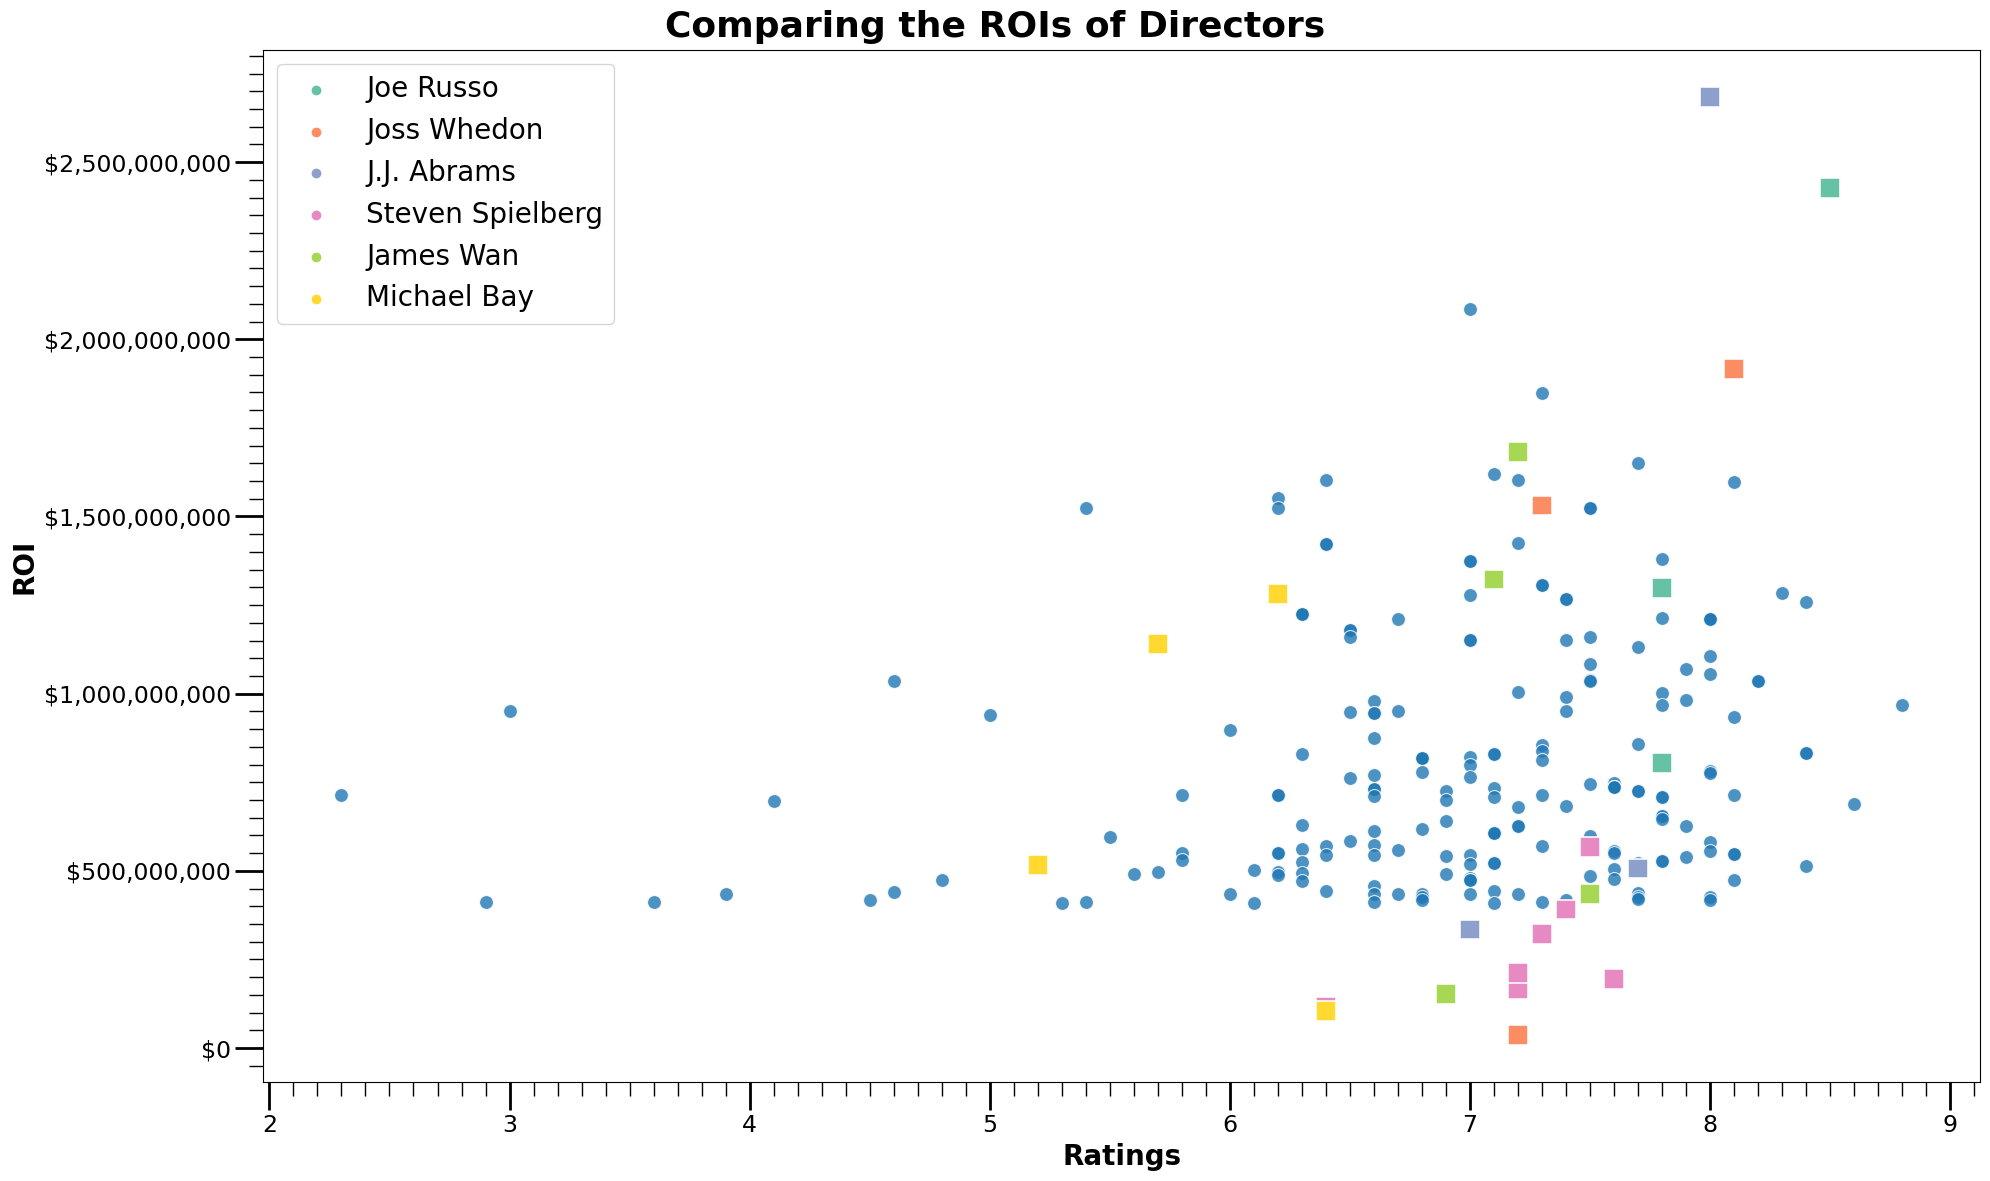

In [31]:
fig = plt.figure(figsize=(20,12), dpi=100)

fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

top_directors_graph = sns.scatterplot(x='rating_average', y='ROI', data=top_directors, legend='full', alpha=0.8, s=100, palette='Set2')
directors_graph = sns.scatterplot(x='rating_average', y='ROI', data=some_directors, legend='full', s=200, hue='director', palette='Set2', marker='s')

ax.yaxis.set_major_locator(MultipleLocator(500000000.00))
ax.yaxis.set_minor_locator(MultipleLocator(50000000))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params('both', length=20, width=2, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Comparing the ROIs of Directors", fontweight='bold', fontsize=26)
ax.set_xlabel("Ratings", fontsize=20, fontweight='bold')
ax.set_ylabel("ROI", fontsize=20, fontweight='bold')

plt.legend(fontsize=20)

plt.tight_layout()

From this graph we can clearly see that Michael Bay, who directed the _Transformer_ series, averaged higher ROIs than Steven Spielberg despite Bay's subpar ratings. It really shows the dominance film series have over the market.

__Creating a bar graph for select directors__

In [32]:
average_profit = {'Joe Russo': russo['ROI'].mean(),
                  'Joss Whedon': whedon['ROI'].mean(),
                  'J.J. Abrams': abrams['ROI'].mean(),
                  'Steven Spielberg': spielberg['ROI'].mean(),
                  'James Wan': wan['ROI'].mean(),
                  'Michael Bay': bay['ROI'].mean()}
average_profit

{'Joe Russo': 1509750763.6666667,
 'Joss Whedon': 1161577983.6666667,
 'J.J. Abrams': 1175036871.3333333,
 'Steven Spielberg': 281059158.85714287,
 'James Wan': 897866644.75,
 'Michael Bay': 760467960.75}

<Figure size 2000x1200 with 0 Axes>

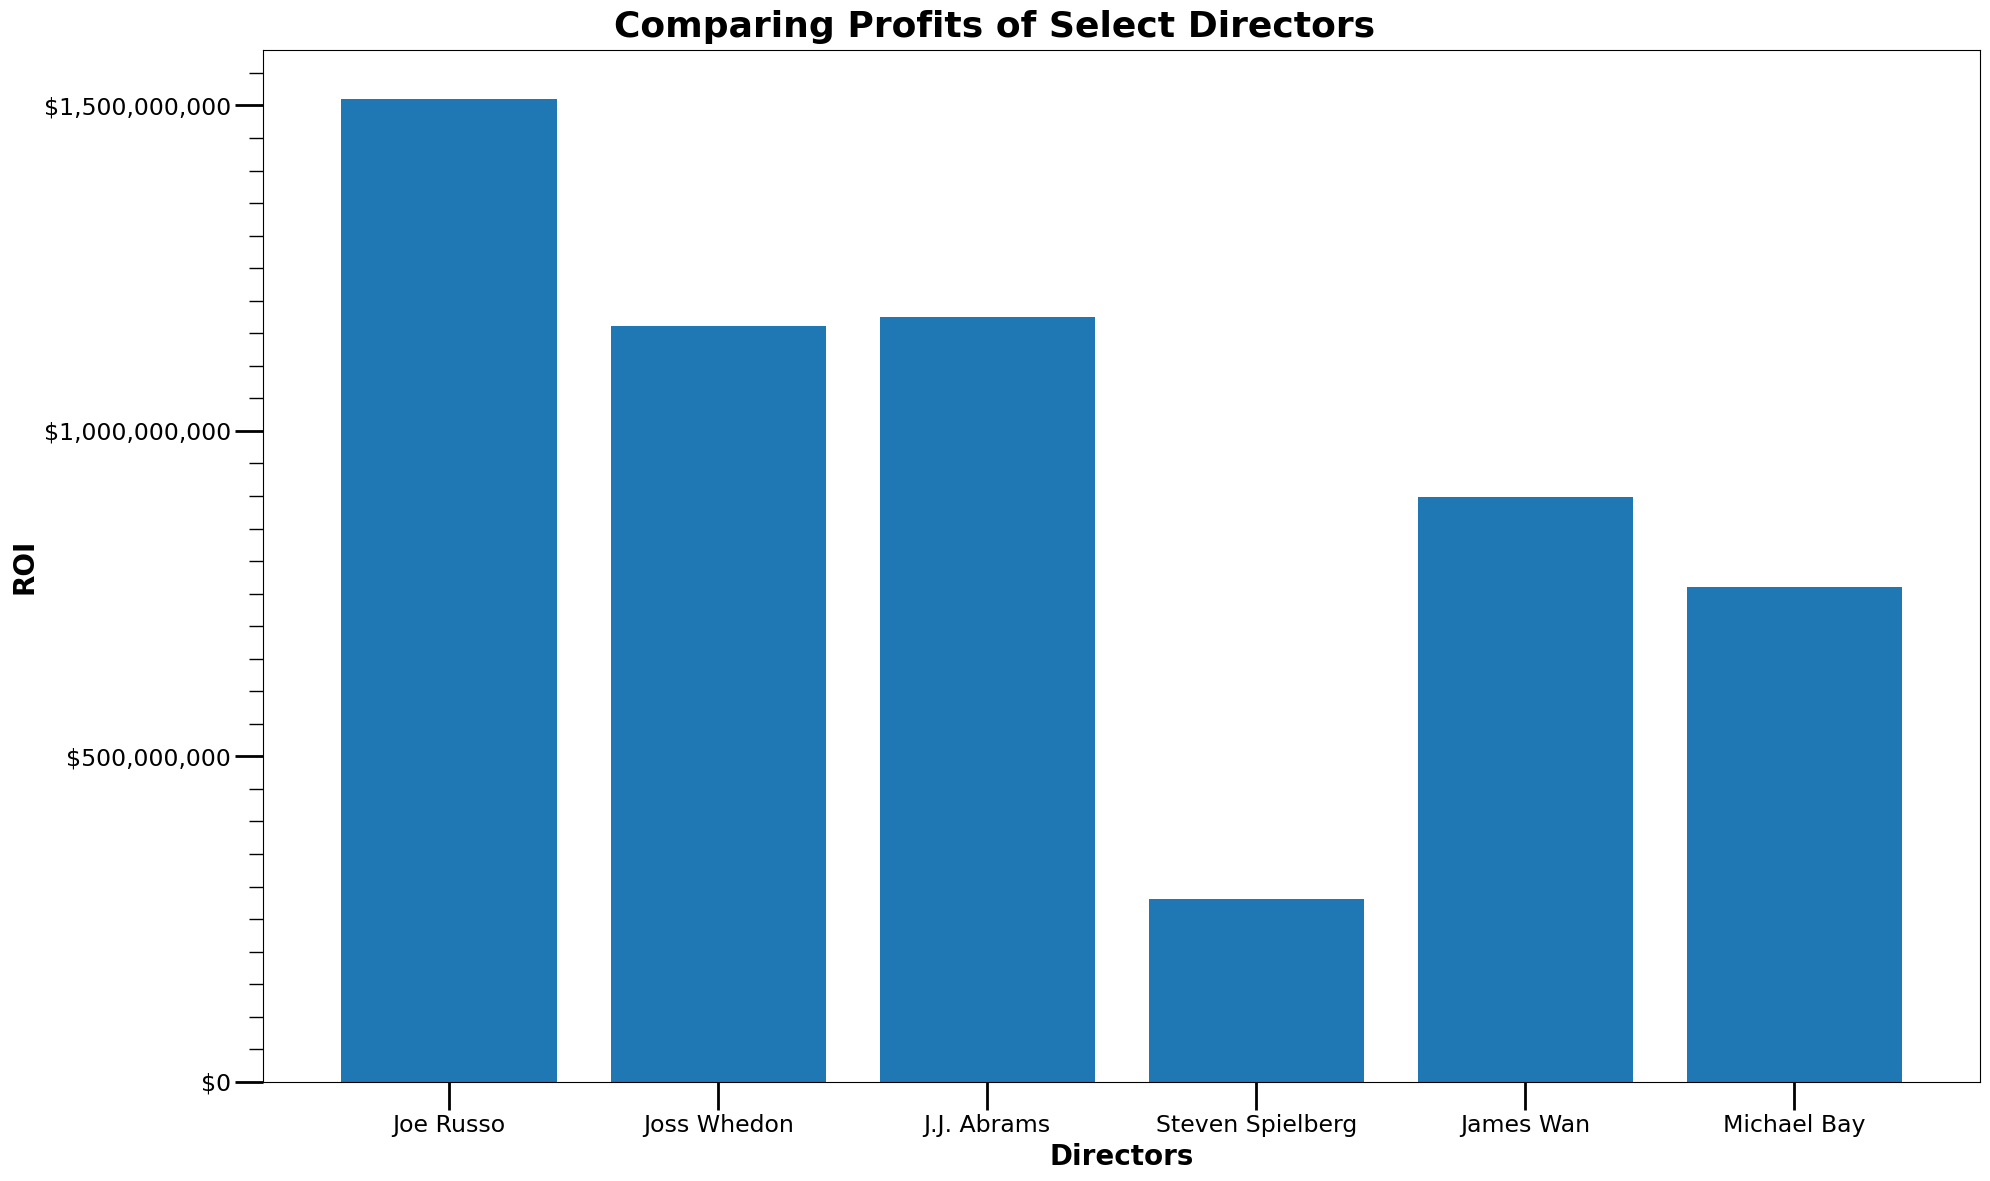

In [33]:
fig = plt.figure(figsize=(20,12), dpi=100)

fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

plt.bar(average_profit.keys(), average_profit.values())

ax.yaxis.set_major_locator(MultipleLocator(500000000.00))
ax.yaxis.set_minor_locator(MultipleLocator(50000000))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.tick_params('both', length=20, width=2, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Comparing Profits of Select Directors", fontweight='bold', fontsize=26)
ax.set_xlabel("Directors", fontsize=20, fontweight='bold')
ax.set_ylabel("ROI", fontsize=20, fontweight='bold')

plt.tight_layout()

__Creating a scatterplot for writers__

We can apply the same procedures to both the writers and actors/actresses. Since we only care about the top writers and actors/actresses, we can make a dataframe containing the top 10%.

In [34]:
top_writers = writers_ROI.sort_values(by='ROI', ascending=False)
top_writers = top_writers.iloc[:516]

A mix of writers who create original content vs. series.

In [35]:
quentin = writers_ROI.loc[writers_ROI['writer'].str.contains('Quentin Tarantino')]
lucas = writers_ROI.loc[writers_ROI['writer'].str.contains('George Lucas')]
coen = writers_ROI.loc[writers_ROI['writer'].str.contains('Joel Coen')]
markus = writers_ROI.loc[writers_ROI['writer'].str.contains('Christopher Markus')]
nolan = writers_ROI.loc[writers_ROI['writer'].str.contains('Christopher Nolan')]
daurio = writers_ROI.loc[writers_ROI['writer'].str.contains('Ken Daurio')]

some_writers = pd.concat([quentin, lucas, coen, markus, nolan, daurio])

<Figure size 2000x1200 with 0 Axes>

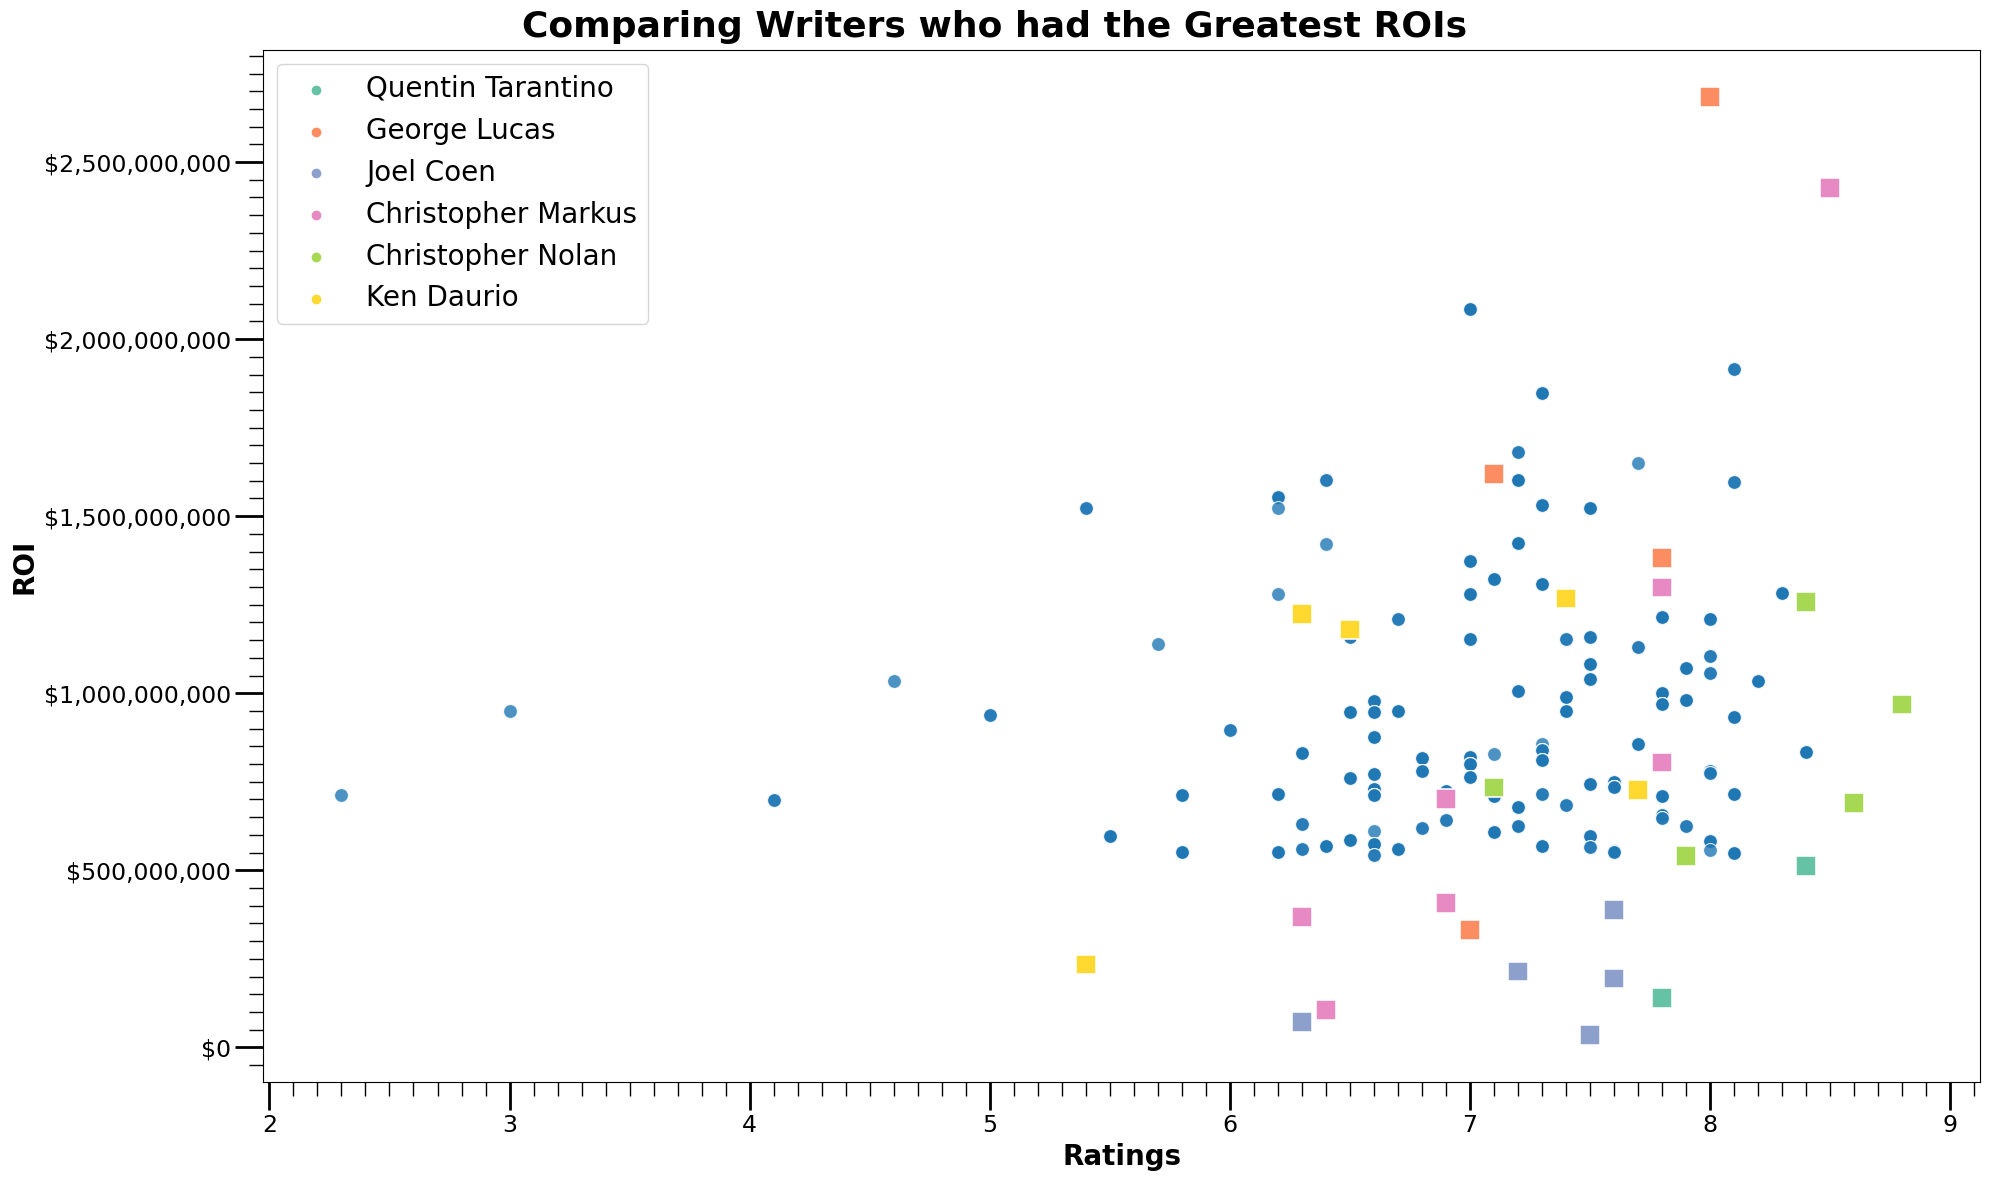

In [36]:
fig = plt.figure(figsize=(20,12), dpi=100)

fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

top_writers_graph = sns.scatterplot(x='rating_average', y='ROI', data=top_writers, legend='full', alpha=0.8, s=100, palette='Set2')
writers_graph = sns.scatterplot(x='rating_average', y='ROI', data=some_writers, legend='full', s=200, hue='writer', palette='Set2', marker='s')

ax.yaxis.set_major_locator(MultipleLocator(500000000.00))
ax.yaxis.set_minor_locator(MultipleLocator(50000000))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params('both', length=20, width=2, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Comparing Writers who had the Greatest ROIs", fontweight='bold', fontsize=26)
ax.set_xlabel("Ratings", fontsize=20, fontweight='bold')
ax.set_ylabel("ROI", fontsize=20, fontweight='bold')

plt.legend(fontsize=20)

plt.tight_layout()

Again, the graph shows the strength of films series in the market. It allows us to compare Ken Daurio's _Despicable Me_ to the scripts of the Coen brothers.

__Creating a bar graph for select writers__

In [37]:
average_profit_writers = {'Quentin Tarantino': quentin['ROI'].mean(),
                          'George Lucas': lucas['ROI'].mean(),
                          'Joel Coen': coen['ROI'].mean(),
                          'Christopher Markus': markus['ROI'].mean(),
                          'Christopher Nolan': nolan['ROI'].mean(),
                          'Ken Daurio': daurio['ROI'].mean()}
average_profit_writers

{'Quentin Tarantino': 326368029.5,
 'George Lucas': 1504268903.25,
 'Joel Coen': 180986021.0,
 'Christopher Markus': 872880815.7142857,
 'Christopher Nolan': 837805397.6,
 'Ken Daurio': 926298118.0}

<Figure size 2000x1200 with 0 Axes>

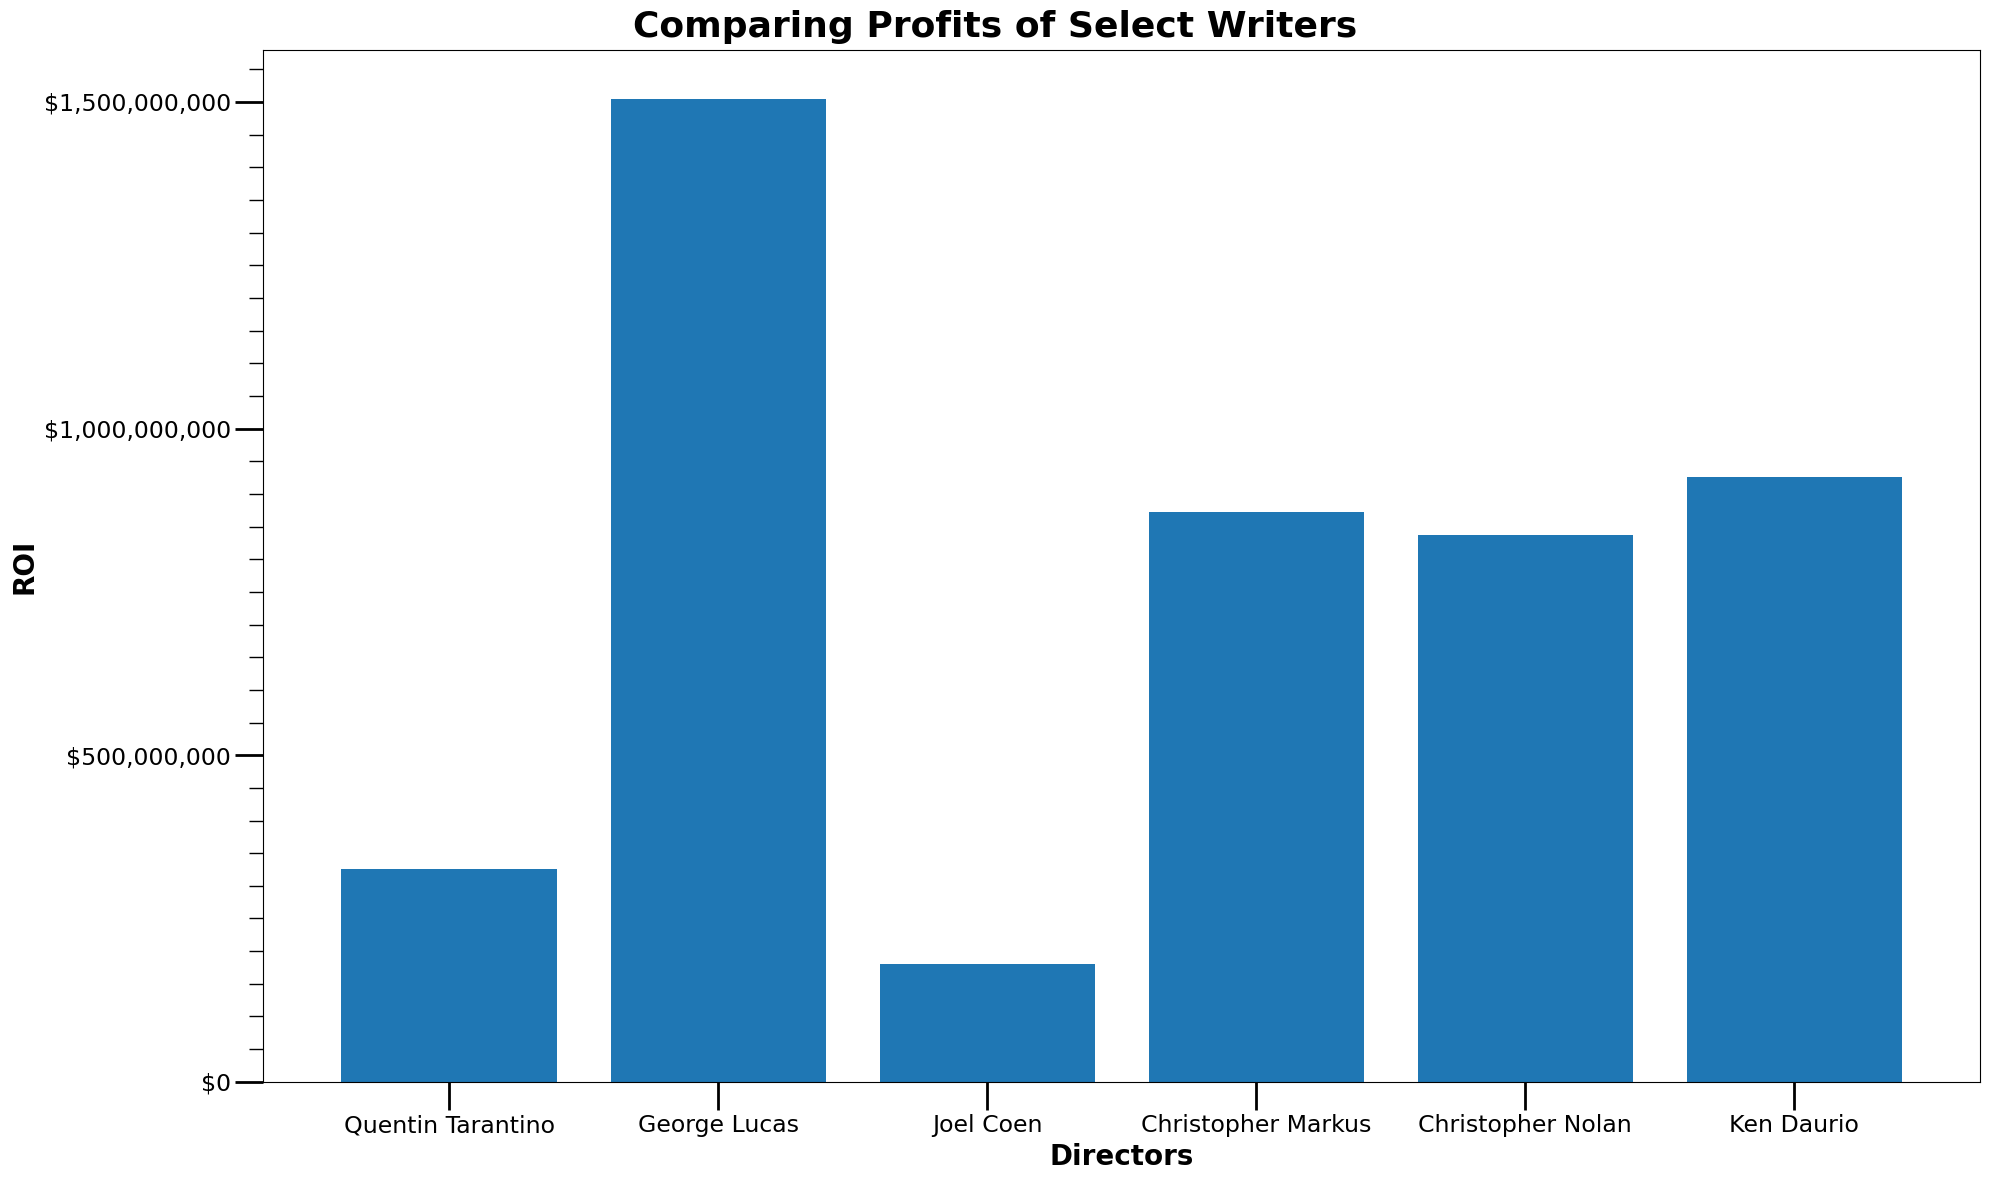

In [38]:
fig = plt.figure(figsize=(20,12), dpi=100)

fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

plt.bar(average_profit_writers.keys(), average_profit_writers.values())

ax.yaxis.set_major_locator(MultipleLocator(500000000.00))
ax.yaxis.set_minor_locator(MultipleLocator(50000000))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.tick_params('both', length=20, width=2, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Comparing Profits of Select Writers", fontweight='bold', fontsize=26)
ax.set_xlabel("Directors", fontsize=20, fontweight='bold')
ax.set_ylabel("ROI", fontsize=20, fontweight='bold')

plt.tight_layout()

__Creating a scatterplot for actors/actresses__

In [39]:
top_famousppl = famousppl_ROI.sort_values(by='ROI', ascending=False)
top_famousppl = top_famousppl.iloc[:5000]

A sample of actors/actresses involved in originals and series.

In [40]:
pitt = famousppl_ROI.loc[famousppl_ROI['renown'].str.contains('Brad Pitt')]
evans = famousppl_ROI.loc[famousppl_ROI['renown'].str.contains('Chris Evans')]
lawrence = famousppl_ROI.loc[famousppl_ROI['renown'].str.contains('Jennifer Lawrence')]
dicaprio = famousppl_ROI.loc[famousppl_ROI['renown'].str.contains('Leonardo DiCaprio')]
vin = famousppl_ROI.loc[famousppl_ROI['renown'].str.contains('Vin Diesel')]
craig = famousppl_ROI.loc[famousppl_ROI['renown'].str.contains('Daniel Craig')]

some_famousppl = pd.concat([pitt, evans, lawrence, dicaprio, vin, craig])

<Figure size 2000x1200 with 0 Axes>

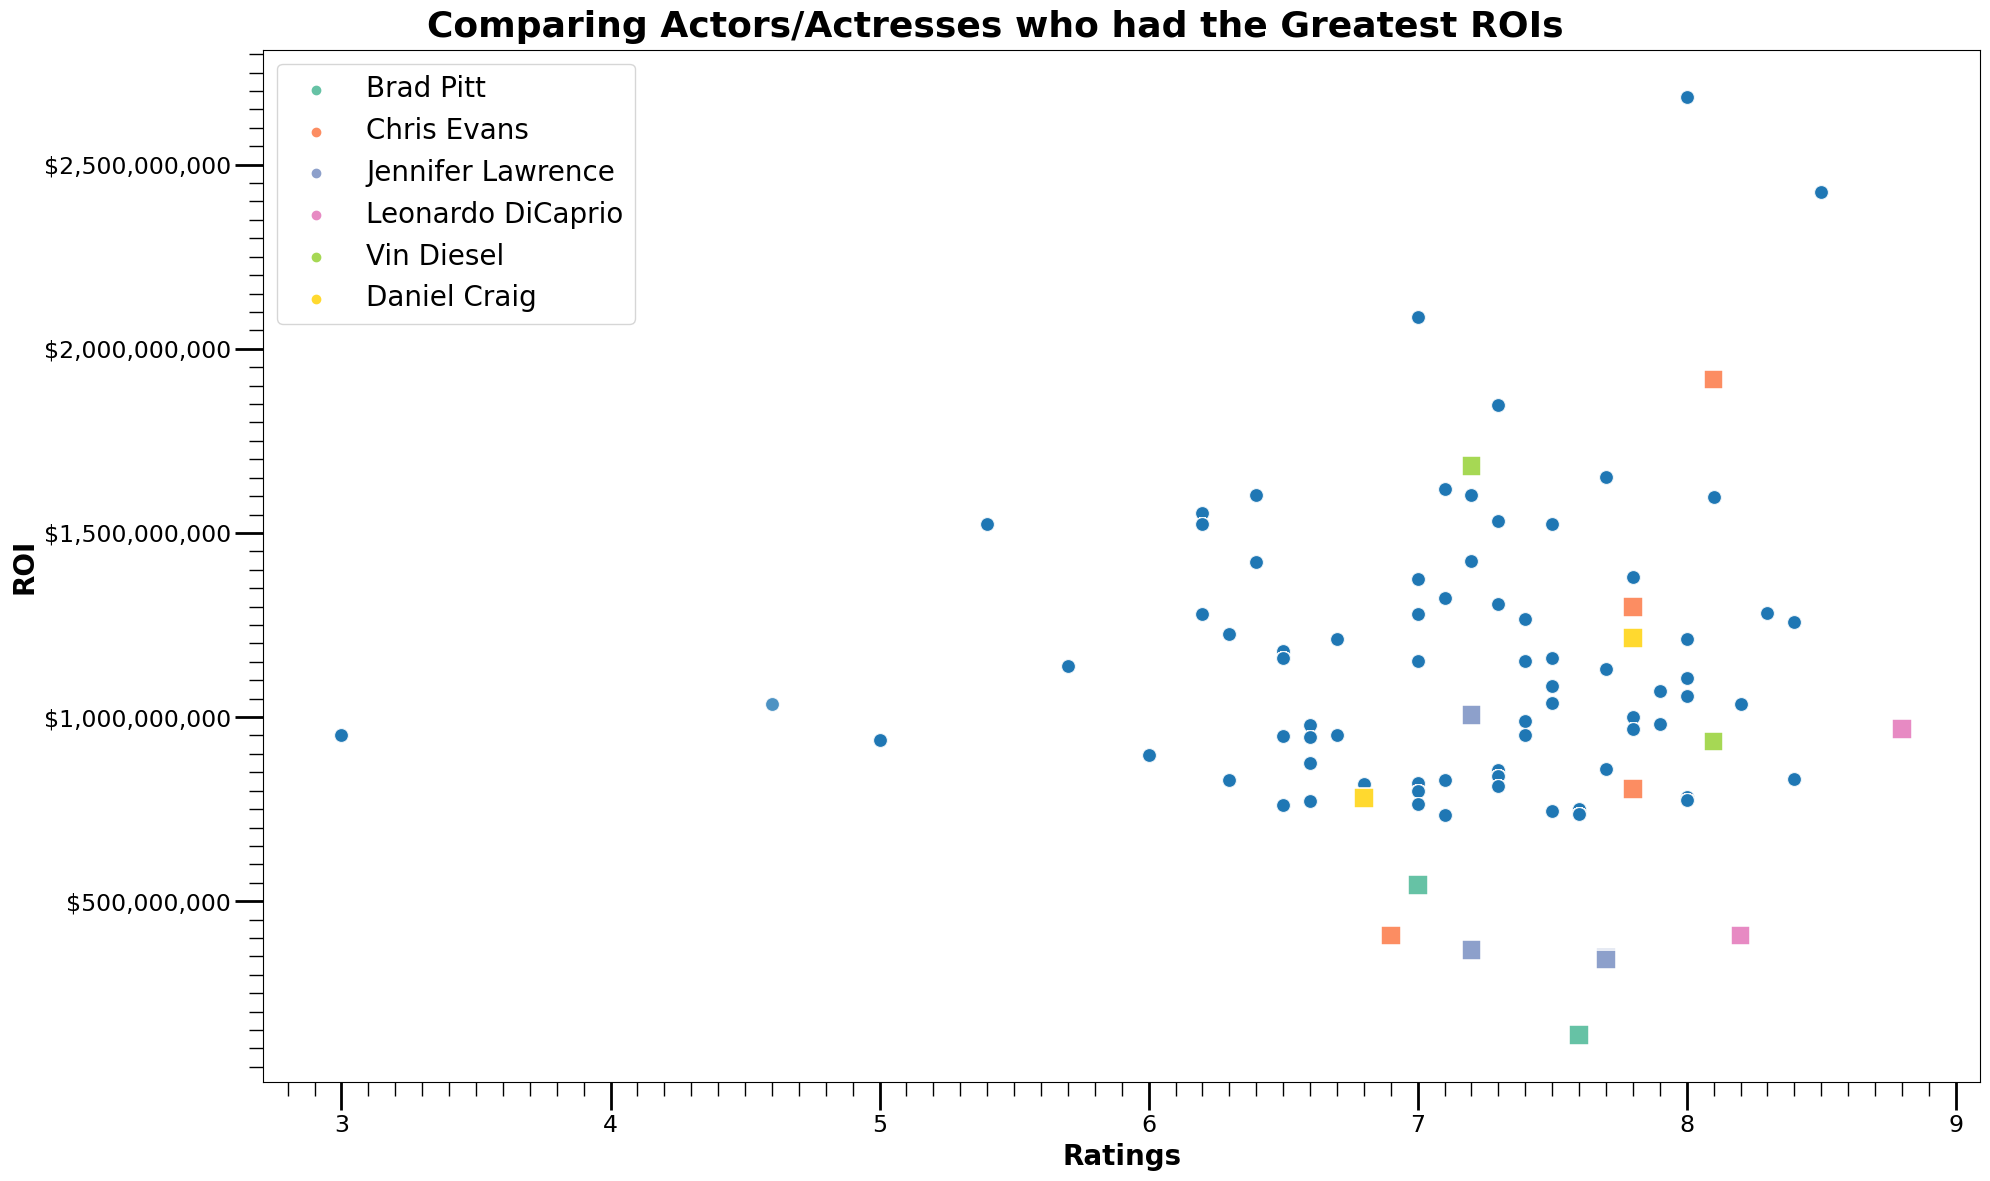

In [41]:
fig = plt.figure(figsize=(20,12), dpi=100)

fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

top_famousppl_graph = sns.scatterplot(x='rating_average', y='ROI', data=top_famousppl, legend='full', alpha=0.8, s=100, palette='Set2')
famousppl_graph = sns.scatterplot(x='rating_average', y='ROI', data=some_famousppl, legend='full', s=200, hue='renown', palette='Set2', marker='s')

ax.yaxis.set_major_locator(MultipleLocator(500000000.00))
ax.yaxis.set_minor_locator(MultipleLocator(50000000))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params('both', length=20, width=2, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Comparing Actors/Actresses who had the Greatest ROIs", fontweight='bold', fontsize=26)
ax.set_xlabel("Ratings", fontsize=20, fontweight='bold')
ax.set_ylabel("ROI", fontsize=20, fontweight='bold')

plt.legend(fontsize=20)

plt.tight_layout()

Same story, different category. We see actors/actresses who work in series earning higher ROI than their competitors. The fact that films with Vin Diesel (_Fast and Furious_) makes more than triple of films starring Brad Pitt really forces the theme that film series can return profit despite having two-dimensional acting. 

__Creating a bar graph for select actors__

In [42]:
average_profit_actors = {'Brad Pitt': pitt['ROI'].mean(),
                          'Chris Evans': evans['ROI'].mean(),
                          'Jennifer Lawrence': lawrence['ROI'].mean(),
                          'Leonardo DiCaprio': dicaprio['ROI'].mean(),
                          'Vin Diesel': vin['ROI'].mean(),
                          'Daniel Craig': craig['ROI'].mean()}
average_profit_actors

{'Brad Pitt': 340390344.0,
 'Chris Evans': 1106435583.5,
 'Jennifer Lawrence': 515813048.25,
 'Leonardo DiCaprio': 687435972.5,
 'Vin Diesel': 1307884721.0,
 'Daniel Craig': 997291178.0}

<Figure size 2000x1200 with 0 Axes>

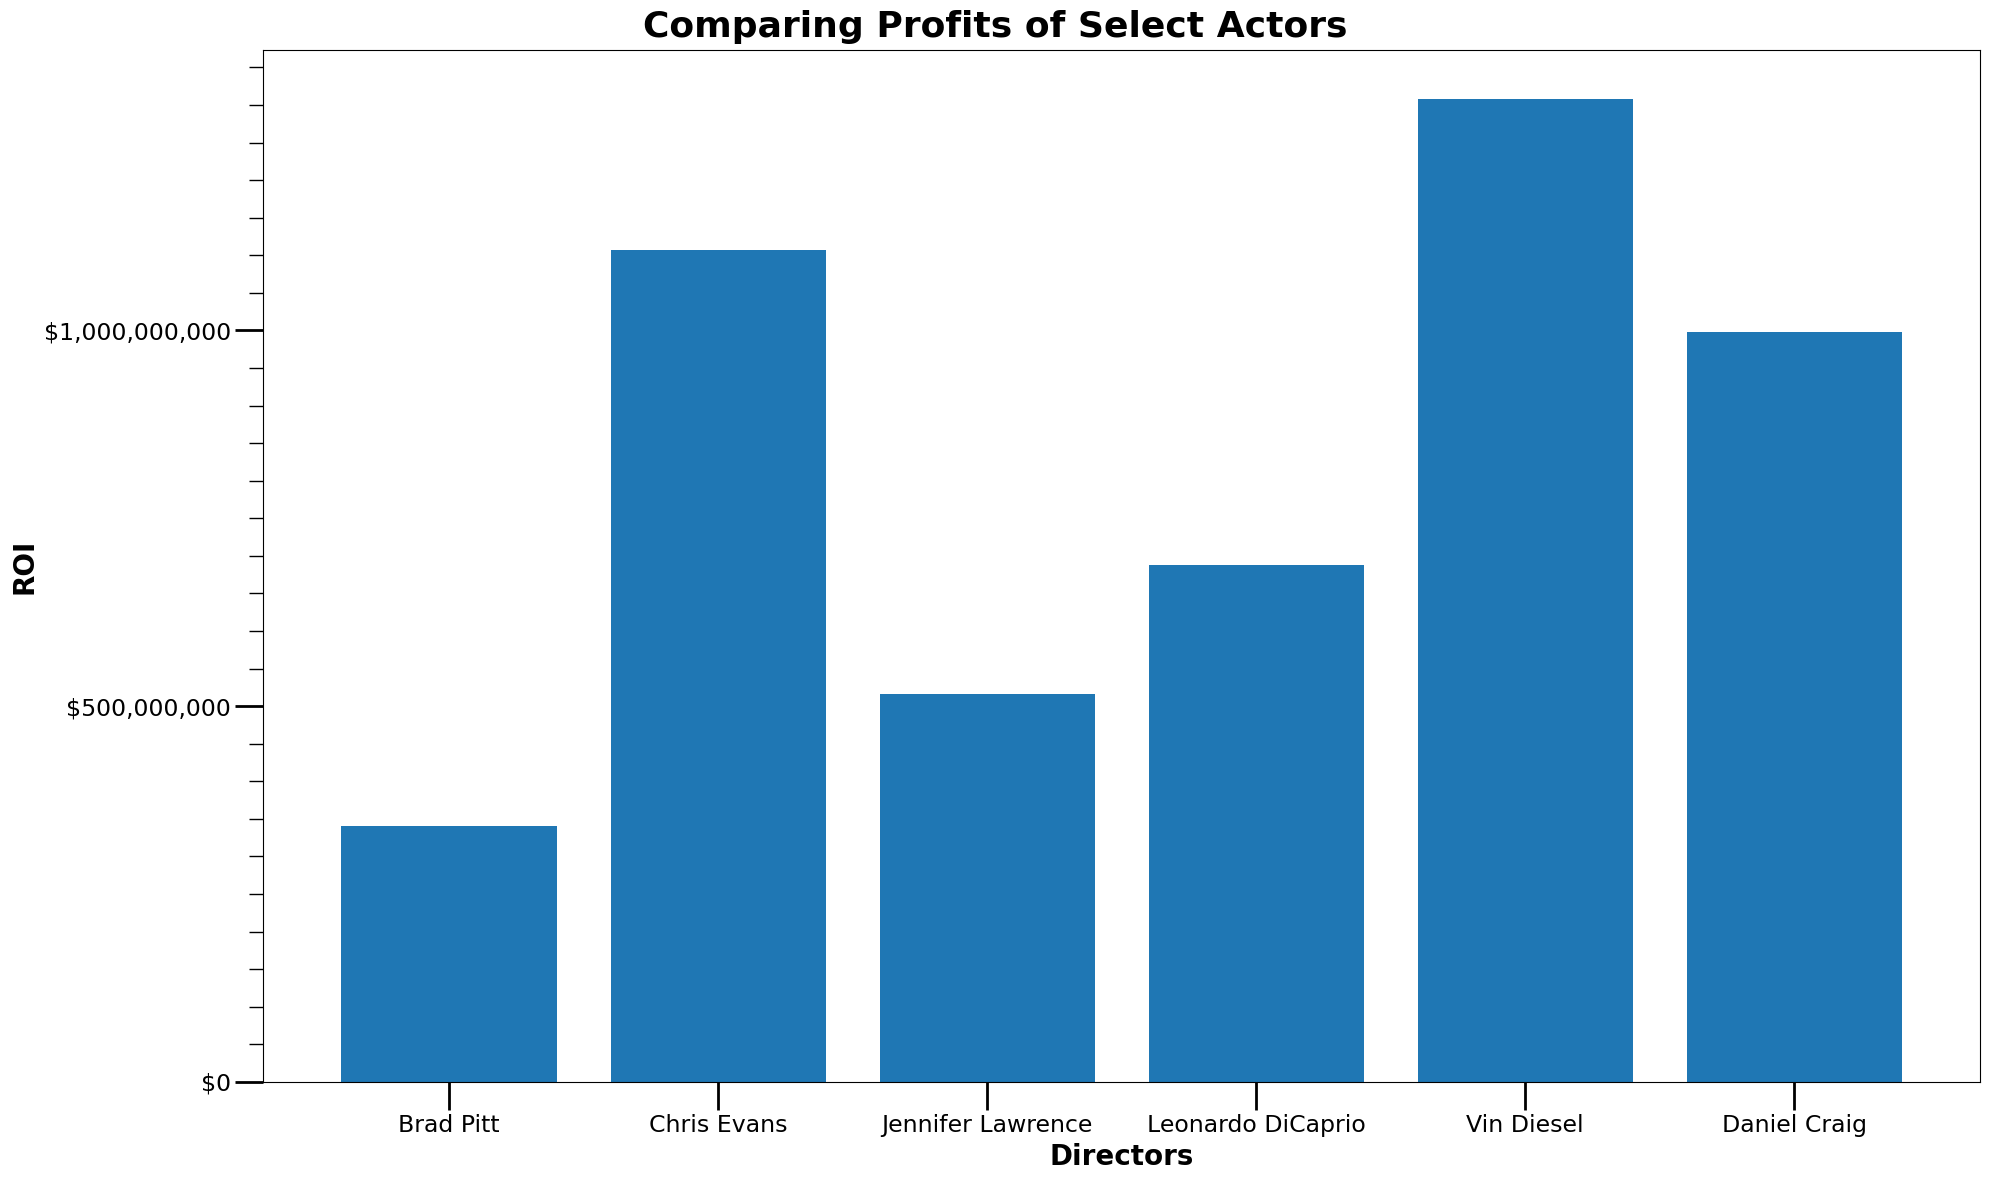

In [43]:
fig = plt.figure(figsize=(20,12), dpi=100)

fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

plt.bar(average_profit_actors.keys(), average_profit_actors.values())

ax.yaxis.set_major_locator(MultipleLocator(500000000.00))
ax.yaxis.set_minor_locator(MultipleLocator(50000000))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.tick_params('both', length=20, width=2, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Comparing Profits of Select Actors", fontweight='bold', fontsize=26)
ax.set_xlabel("Directors", fontsize=20, fontweight='bold')
ax.set_ylabel("ROI", fontsize=20, fontweight='bold')

plt.tight_layout()

__Creating a histogram that relates genre to ROI__
* We can obtain values of specific genres by using the same method: `.str.contains(**genre**)`
* Then use `.assign(Genre='genre')` to create a new column of genre values.

In [44]:
action = top_directors.loc[top_directors['genres'].str.contains('Action')].assign(Genre='Action')
adventure = top_directors.loc[top_directors['genres'].str.contains('Adventure')].assign(Genre='Adventure')
scifi = top_directors.loc[top_directors['genres'].str.contains('Sci-Fi')].assign(Genre='Sci-Fi')
comedy = top_directors.loc[top_directors['genres'].str.contains('Comedy')].assign(Genre='Comedy')
drama = top_directors.loc[top_directors['genres'].str.contains('Drama')].assign(Genre='Drama')
fantasy = top_directors.loc[top_directors['genres'].str.contains('Fantasy')].assign(Genre='Fantasy')
animation = top_directors.loc[top_directors['genres'].str.contains('Animation')].assign(Genre='Animation')
horror = top_directors.loc[top_directors['genres'].str.contains('Horror')].assign(Genre='Horror')
family = top_directors.loc[top_directors['genres'].str.contains('Family')].assign(Genre='Family')

concat_genres = pd.concat([action, adventure, scifi, comedy, drama, fantasy, animation, horror, family])

Text(0, 0.5, 'Count')

<Figure size 2000x1200 with 0 Axes>

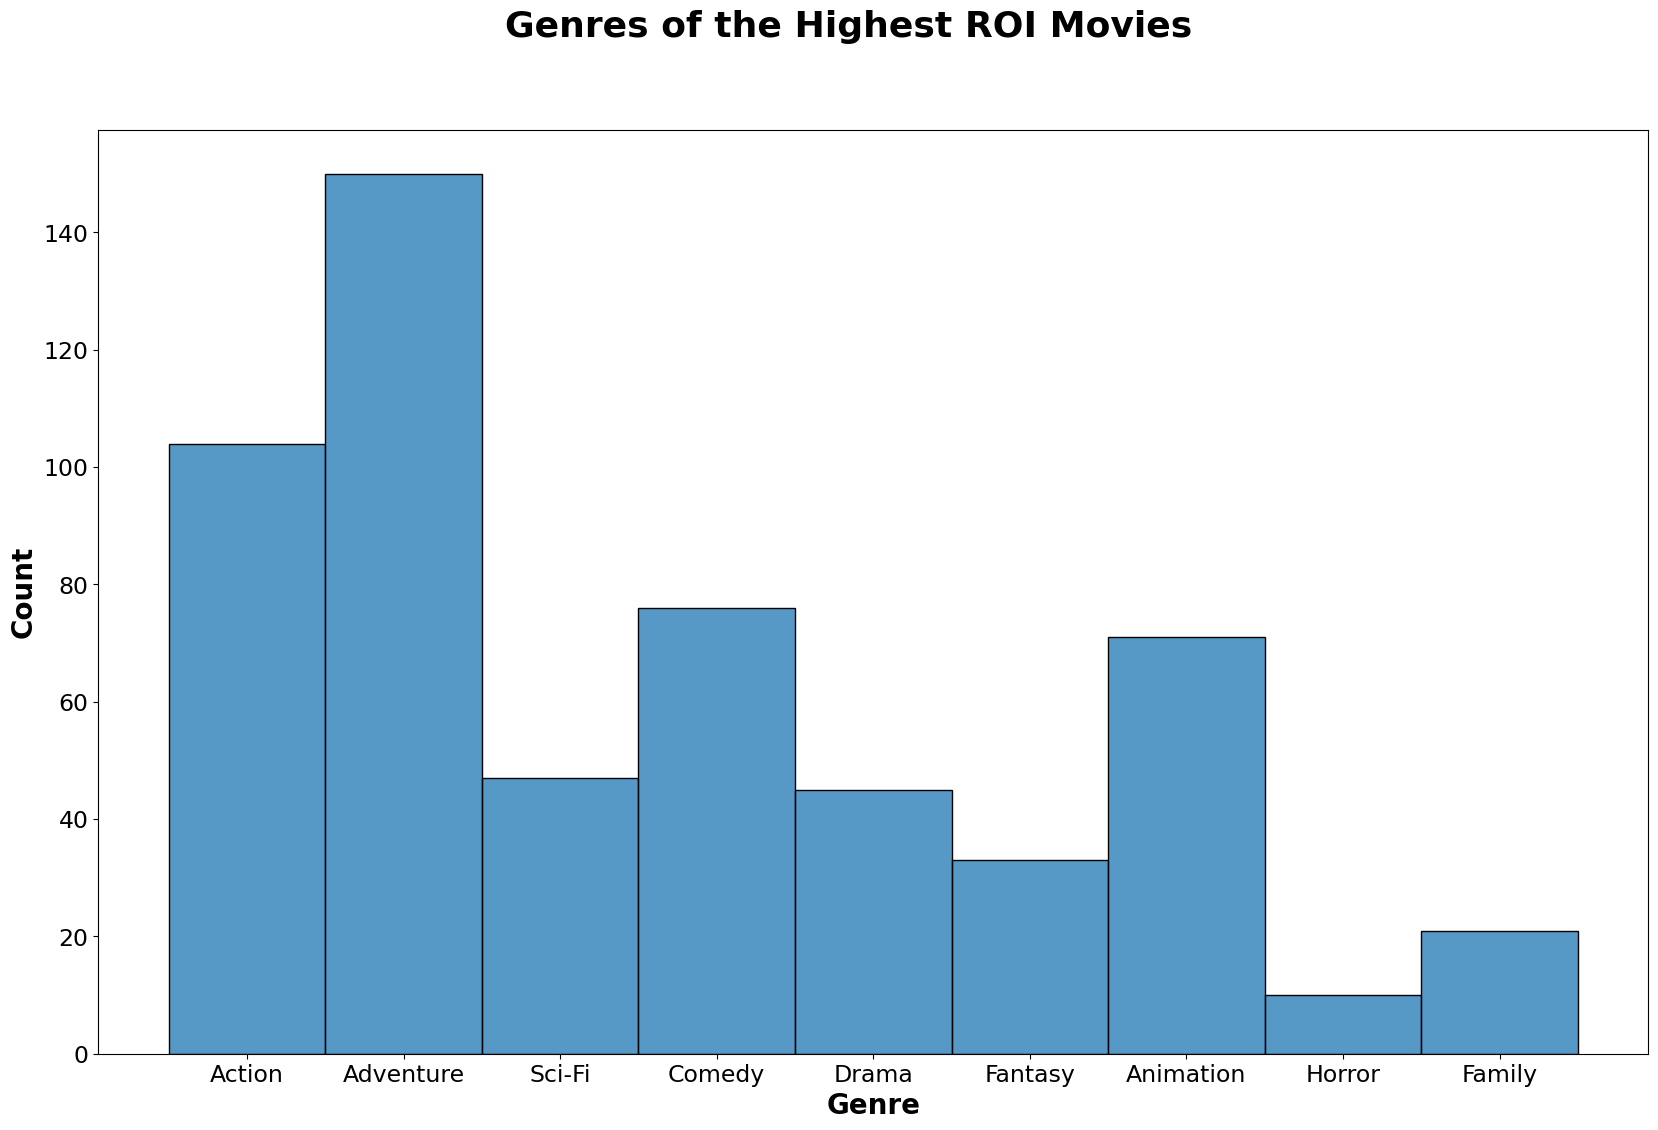

In [45]:
fig = plt.figure(figsize=(20,12), dpi=100)

fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

graph = sns.histplot(data=concat_genres.Genre)

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Genres of the Highest ROI Movies", fontweight='bold', fontsize=26)
ax.set_xlabel("Genre", fontsize=20, fontweight='bold')
ax.set_ylabel("Count", fontsize=20, fontweight='bold')

The histograms reveals which genres are most prevalent in this data set. The high amounts of action and adventure films are most likely due to the high concentration of popular series like Marvel and Star Wars. 

__Creating a histogram based on percent change__

Having a high ROI is not the only metric of measuring a film's success. We can also measure the film's percent change. This can level the playing field for non-blockbuster films that did well relative to their production budget. <br>We will create two dataframes that contains genres with the highest and the lowest percent change. <br>We should use the same genres as the previous histogram so we can observe the differences.

In [46]:
# Using the data from the directors dataframe, but writers and famousppl should work the same.
directors_percent = directors_ROI.sort_values(by='Percent_change', ascending=False)

top_genres = directors_percent.iloc[:220]
bot_genres = directors_ROI.sort_values(by='Percent_change', ascending=True).iloc[:220]

We can use the same code as before but for a different dataframe

In [47]:
# For the top percent changes
action = top_genres.loc[top_genres['genres'].str.contains('Action')].assign(Genre='Action')
adventure = top_genres.loc[top_genres['genres'].str.contains('Adventure')].assign(Genre='Adventure')
scifi = top_genres.loc[top_genres['genres'].str.contains('Sci-Fi')].assign(Genre='Sci-Fi')
comedy = top_genres.loc[top_genres['genres'].str.contains('Comedy')].assign(Genre='Comedy')
drama = top_genres.loc[top_genres['genres'].str.contains('Drama')].assign(Genre='Drama')
fantasy = top_genres.loc[top_genres['genres'].str.contains('Fantasy')].assign(Genre='Fantasy')
animation = top_genres.loc[top_genres['genres'].str.contains('Animation')].assign(Genre='Animation')
horror = top_genres.loc[top_genres['genres'].str.contains('Horror')].assign(Genre='Horror')
family = top_genres.loc[top_genres['genres'].str.contains('Family')].assign(Genre='Family')

concat_percent = pd.concat([action, adventure, scifi, comedy, drama, fantasy, animation, horror, family])

In [48]:
# For the lower percent changes
action = bot_genres.loc[bot_genres['genres'].str.contains('Action')].assign(Genre='Action')
adventure = bot_genres.loc[bot_genres['genres'].str.contains('Adventure')].assign(Genre='Adventure')
scifi = bot_genres.loc[bot_genres['genres'].str.contains('Sci-Fi')].assign(Genre='Sci-Fi')
comedy = bot_genres.loc[bot_genres['genres'].str.contains('Comedy')].assign(Genre='Comedy')
drama = bot_genres.loc[bot_genres['genres'].str.contains('Drama')].assign(Genre='Drama')
fantasy = bot_genres.loc[bot_genres['genres'].str.contains('Fantasy')].assign(Genre='Fantasy')
animation = bot_genres.loc[bot_genres['genres'].str.contains('Animation')].assign(Genre='Animation')
horror = bot_genres.loc[bot_genres['genres'].str.contains('Horror')].assign(Genre='Horror')
family = bot_genres.loc[bot_genres['genres'].str.contains('Family')].assign(Genre='Family')

concat_bot_percent = pd.concat([action, adventure, scifi, comedy, drama, fantasy, animation, horror, family])

Create the histogram

Text(0, 0.5, 'Count')

<Figure size 2000x1200 with 0 Axes>

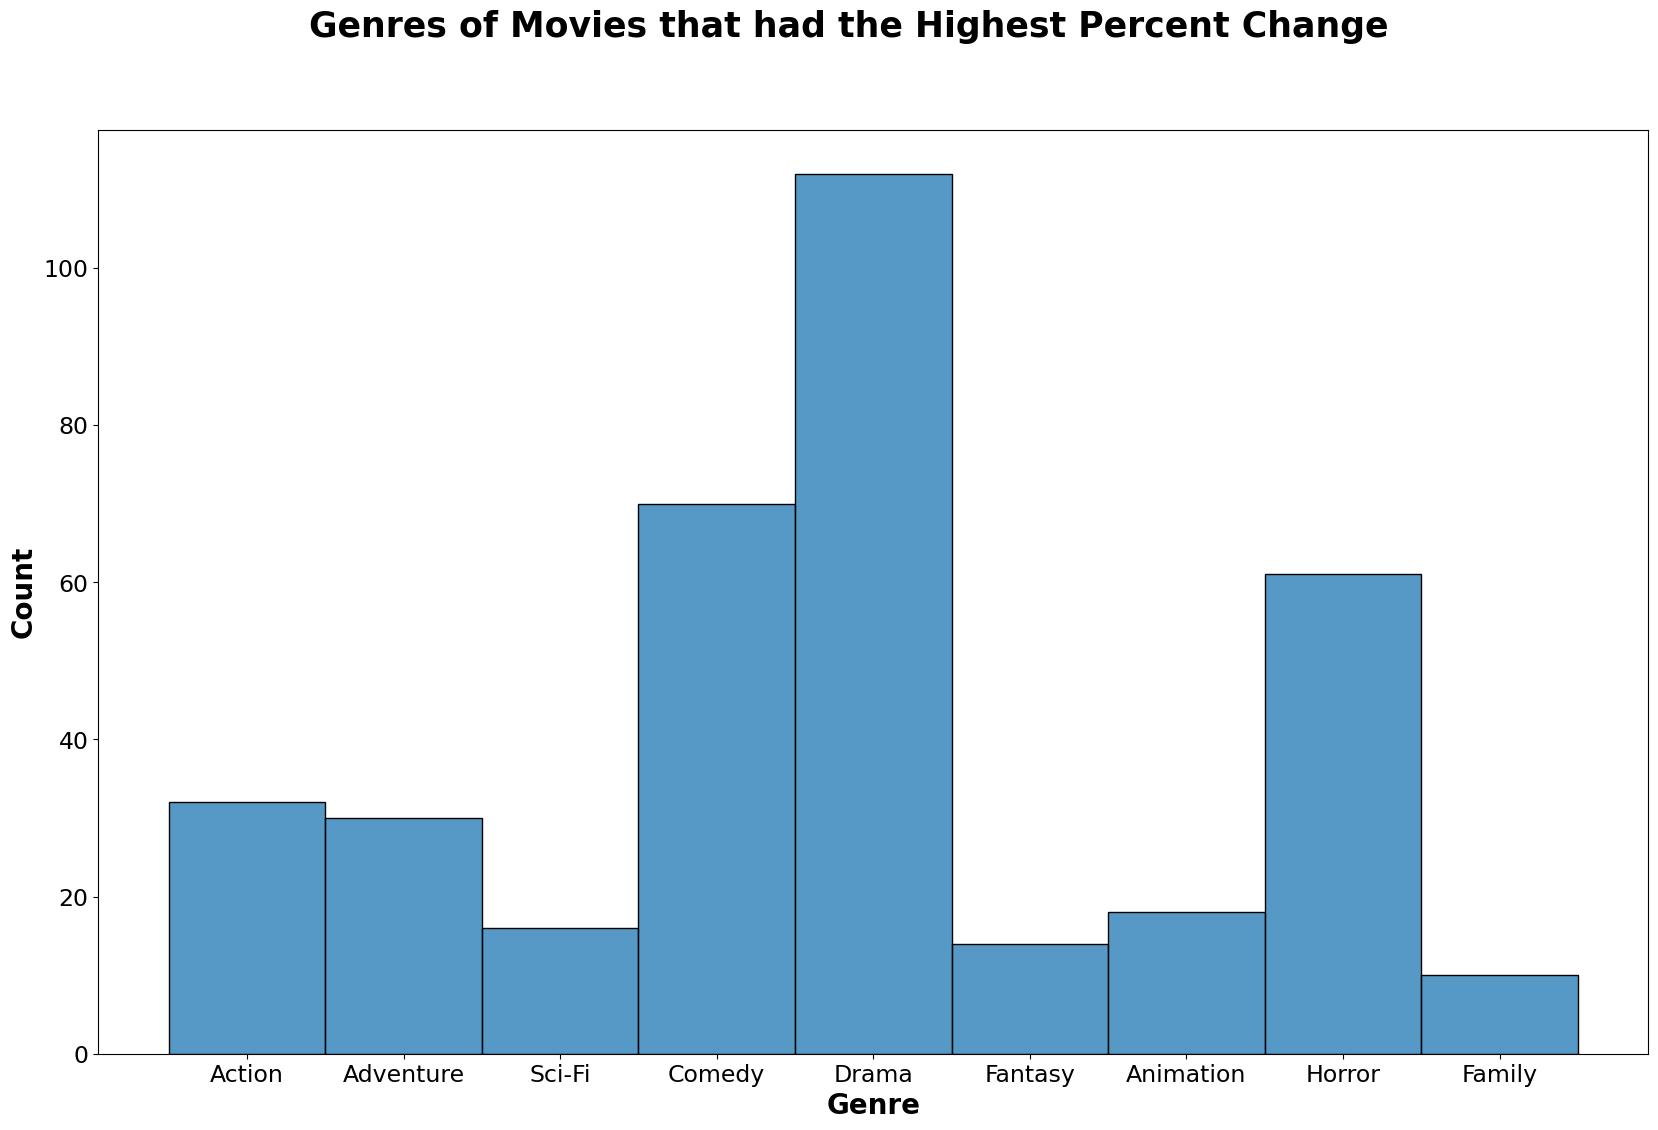

In [49]:
fig = plt.figure(figsize=(20,12), dpi=100)

fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

graph = sns.histplot(data=concat_percent.Genre)

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Genres of Movies that had the Highest Percent Change", fontweight='bold', fontsize=25)
ax.set_xlabel("Genre", fontsize=20, fontweight='bold')
ax.set_ylabel("Count", fontsize=20, fontweight='bold')

Popular action series do require a high budget and while it does return a great profit, does it return the highest percentage? This chart indicates otherwise.

Text(0, 0.5, 'Count')

<Figure size 2000x1200 with 0 Axes>

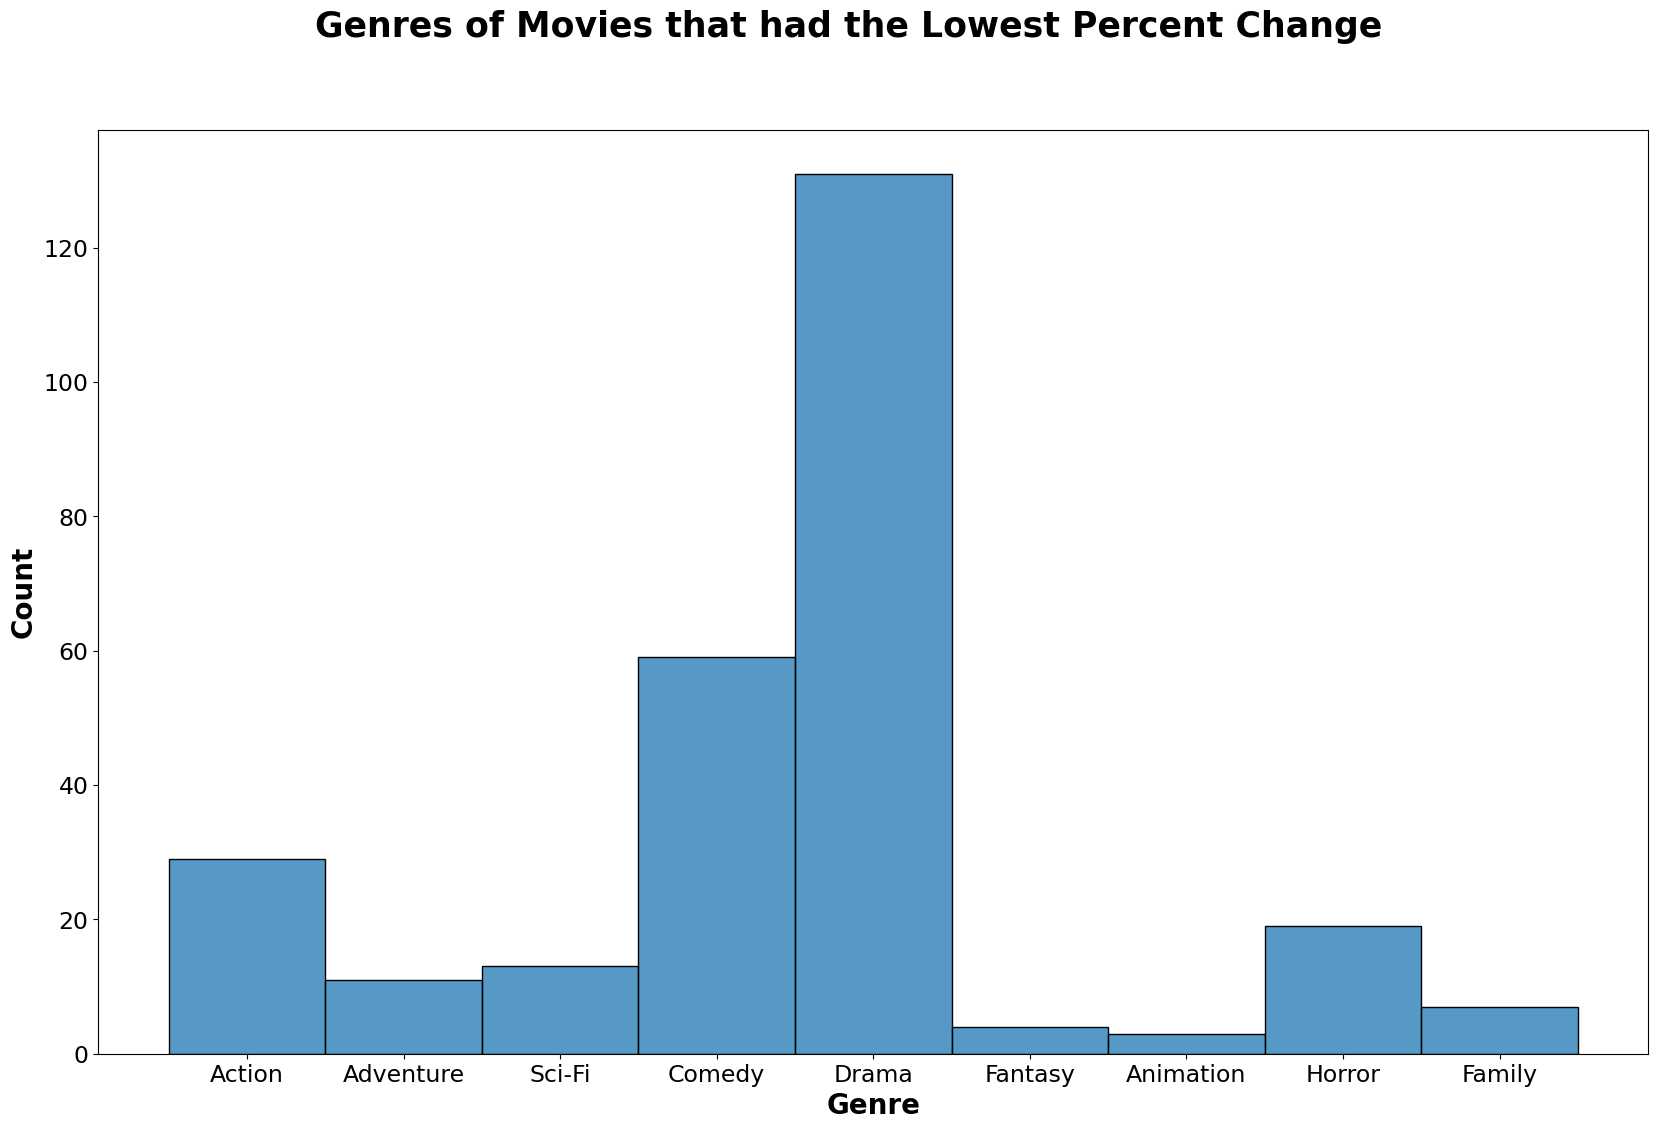

In [50]:
fig = plt.figure(figsize=(20,12), dpi=100)

fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

graph = sns.histplot(data=concat_bot_percent.Genre)

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Genres of Movies that had the Lowest Percent Change", fontweight='bold', fontsize=25)
ax.set_xlabel("Genre", fontsize=20, fontweight='bold')
ax.set_ylabel("Count", fontsize=20, fontweight='bold')

However, it seems like investing in comedy or drama films may be bit of a gamble whereas horror films seem like a safer bet.

# Calculating the Mean

Finally we can calculate the mean for ROI, budget, and percent change.

In [51]:
print('This is the average production budget of all films: ${:,.2f}'.format(budget['production_budget'].mean()))
print('This is the average profit of all films: ${:,.2f}'.format(budget['ROI'].mean()))
print('This is the average rating of all flims:', concat_directors['rating_average'].mean())

This is the average production budget of all films: $34,033,480.05
This is the average profit of all films: $112,985,491.90
This is the average rating of all flims: 6.350614035087721


In [52]:
print('This is the average production budget for movies with the greatest ROI: ${:,.2f}'.format(top_directors['production_budget'].mean()))
print('This is the average profit for movies with the greatest ROI: ${:,.2f}'.format(top_directors['ROI'].mean()))
print('This is the average rating for movies with the greatest ROI:', top_directors['rating_average'].mean())
print('This is the average percent increase for movies with the greatest ROI: ', top_directors['Percent_change'].mean())

This is the average production budget for movies with the greatest ROI: $139,244,090.91
This is the average profit for movies with the greatest ROI: $842,331,776.57
This is the average rating for movies with the greatest ROI: 6.980909090909087
This is the average percent increase for movies with the greatest ROI:  956.1409486207693


In [53]:
print('This is the average production budget for the movies with the greatest percent change: ${:,.2f}'.format(top_genres['production_budget'].mean()))
print('This is the average profit for the movies with the greatest percent change: ${:,.2f}'.format(top_genres['ROI'].mean()))
print('This is the average rating for movies with the greatest percent change:', top_genres['rating_average'].mean())
print('This is the average percent increase for the movies with the greatest percent change:', top_genres['Percent_change'].mean())

This is the average production budget for the movies with the greatest percent change: $16,030,030.23
This is the average profit for the movies with the greatest percent change: $270,475,655.32
This is the average rating for movies with the greatest percent change: 6.52272727272727
This is the average percent increase for the movies with the greatest percent change: 3333.9820113243195


# Conclusion
Film series do exceedingly well compared to original titles. This may be due to the cult following some series have (i.e. _Marvel_) as opposed to a new intellectual property (IP). Because a new IP may not have the initial fanbase as _Star Wars_ does, studios should be more aware of who they hire as their director, writer, actors, etc. These element affect ratings which ultimately can determine a film's ROI.

On the otherhand, if a studio's objective is to have the greatest ROI without the care for ratings, they can look to different genres (i.e. horror). These are films with high ROI relative to their budget despite their lower ratings. This may be enticing to studios with lower liquidity as well.